# Amazon Fine Food Reviews Analysis
The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.

 Number of reviews: 568,454                                                                                                     
 Number of users: 256,059                                                                                                       
 Number of products: 74,258                                                                                                                                                                                                             
 Number of Attributes/Columns in data: 10
 
 Attributes:
1. IdRow Id
2. ProductIdUnique identifier for the product
3. UserIdUnqiue identifier for the user
4. ProfileNameProfile name of the user
5. HelpfulnessNumeratorNumber of users who found the review helpful
6. HelpfulnessDenominatorNumber of users who indicated whether they found the review helpful
7. ScoreRating between 1 and 5
8. TimeTimestamp for the review
9. SummaryBrief summary of the review
10. TextText of the review

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import sqlite3
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,classification_report,f1_score
from sklearn.decomposition import TruncatedSVD
from sklearn import cross_validation
from sklearn.cross_validation import cross_val_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import gensim

In [23]:
con = sqlite3.connect('./AmazonFFR/database.sqlite')

# not taking into consideration those reviews with Score=3 as we need only positive and negative reviews
filtered_data = pd.read_sql_query("""
SELECT * FROM Reviews
WHERE Score !=3""",con)

In [24]:
def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'

#changing reviews with score greater than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative

In [25]:
filtered_data_final = filtered_data #looking at the number of attributes and size of the data

In [26]:
filtered_data_final['Score'].value_counts()

positive    443777
negative     82037
Name: Score, dtype: int64

In [27]:
# Data Cleaning :Duplication

sort_data = filtered_data_final.sort_values('ProductId',axis =0,ascending=True)

final = sort_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"},keep='first',inplace=False)

final = final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [28]:
filtered_data_final.sort_values('Time')

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...
138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,positive,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...
417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,positive,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...
417859,451878,B00004CXX9,A344SMIA5JECGM,Vincent P. Ross,1,2,positive,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta..."
212472,230285,B00004RYGX,A344SMIA5JECGM,Vincent P. Ross,1,2,positive,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta..."
346055,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,positive,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta..."
417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,positive,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...
417927,451949,B00004CXX9,A1048CYU0OV4O8,Judy L. Eans,2,2,positive,947376000,GREAT,THIS IS ONE MOVIE THAT SHOULD BE IN YOUR MOVIE...
212533,230348,B00004RYGX,A1048CYU0OV4O8,Judy L. Eans,2,2,positive,947376000,GREAT,THIS IS ONE MOVIE THAT SHOULD BE IN YOUR MOVIE...
346116,374422,B00004CI84,A1048CYU0OV4O8,Judy L. Eans,2,2,positive,947376000,GREAT,THIS IS ONE MOVIE THAT SHOULD BE IN YOUR MOVIE...


# Data Preprocessing

In [63]:
#Checking the counts of postive and negative reviews

final['Score'].value_counts()

positive    307061
negative     57110
Name: Score, dtype: int64

In [86]:
# Randomly sample 10k points from both class

data_pos = final[final["Score"] == "positive"].sample(n = 500)
data_neg = final[final["Score"] == "negative"].sample(n = 500)
final_data = pd.concat([data_pos, data_neg])

final_data['Score'].value_counts()

positive    500
negative    500
Name: Score, dtype: int64

# 7.2.3 Text Preprocessing: Stemming, stop-word removal and Lemmatization.

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)
8. After which we collect the words used to describe positive and negative reviews

In [87]:
# find sentences containing HTML tags
import re
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
i=0;
for sent in final_data['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break;
    i += 1;

6
This is really a fantastic little product.  I am using mine for the first time this morning to brew some Yerba mate 'gringo style' and it works great.<br /><br />I would give it five stars but the other reviewer has a point, the holes on the bottom of the infuser do let out little pieces of the tea, however a bit of common sense can get around this problem.<br /><br />After you load up your tea and put the lid on the infuser, turn it upside town (holes up), and shake vigorously.  The small particles will sift to the bottom (the top) so when you turn it back over they're all at the top of the tea.  Problem solved.<br /><br />One other problem I just discovered is that the lid of the infuser doesn't seal so after you're done making your tea and you turn the infuser over to set it down (holes up) the liquid still in the tea slowly leaks out the bottom to make a small mess on your counter.  Not cool!


In [88]:
stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

In [89]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
# this code takes a while to run as it needs to run on 500k sentences.
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final_data['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final_data['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final_data['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    
    final_string.append(str1)
    i+=1

In [90]:
final_data['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 
final_data['CleanedText']=final_data['CleanedText'].str.decode("utf-8")

In [91]:
X = final_data["CleanedText"]

X.shape

(1000,)

In [92]:
y = final_data['Score']
y.shape

(1000,)

# KNN with KdTree and Brute

In [93]:
def determineknn(X_1_input,X_test_input,y_1_input,y_test_input,VectorizationType):
    
    cv_scores = []
    algorithm = ['kd_tree','brute']
    
    myList = list(range(0,50))
    neighbors = list(filter(lambda x: x % 2 != 0, myList))
    
    for algo in algorithm:
        # since kd_tree cannot consume Sparse Matrix. Converting Sparse Matrix to Dense using Truncated SVD.
        
        if algo == 'kd_tree':
            svd = TruncatedSVD()
            X_tr_input1 = svd.fit_transform(X_1_input)
            x_test_input1 = svd.fit_transform(X_test_input)
            X_1_input = X_tr_input1
            X_test_input = x_test_input1
        
        for i in neighbors:
            knn = KNeighborsClassifier(n_neighbors=i,algorithm = algo)

            scores = cross_val_score(knn, X_1_input, y_1_input, cv=10, scoring='accuracy')
            cv_scores.append(scores.mean())
        
        # changing to misclassification error
        MSE = []
        for x in cv_scores:
            MSE.append(1-x)

        k_optimum = neighbors[MSE.index(min(MSE))]
        
        plt.plot(neighbors, MSE)

        plt.xlabel('Number of Neighbors K')
        plt.ylabel('Misclassification Error')
        plt.show()
        
        MSE.clear()
        cv_scores.clear()
        
        knn = KNeighborsClassifier(n_neighbors=k_optimum,algorithm = algo)
        # fitting the model on crossvalidation train
        knn.fit(X_1_input, y_1_input)

        # predict the response on test
        pred = knn.predict(X_test_input)
        
        #Accuracy on train data
        train_acc = knn.score(X_1_input, y_1_input)
        train_err = 1-train_acc
        
        #Accuracy on test data
        test_acc = accuracy_score(y_test_input, pred)*100
        test_err = 1- test_acc
        
        # evaluate test accuracy
        #acc = accuracy_score(test, pred, normalize=True) * float(100)
        print('Details for ',VectorizationType,'Vectorization:')
        print('*'*100)
        print('Accuracy for',algo,' algorithm with K =',k_optimum,' is ' ,np.round(accuracy_score(y_test_input, pred)*100))
        print ('\n clasification report for',algo,' algorithm with K =',k_optimum,' is \n ' , classification_report(y_test_input,pred))
        print ('\n confussion matrix for',algo,' algorithm with K =',k_optimum,' is \n' ,confusion_matrix(y_test_input, pred))
        
        cm= confusion_matrix(y_test_input, pred)
        class_label = ["negative", "positive"]
        df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
        sns.heatmap(df_cm, annot = True, fmt = "d")
        plt.title("Confusion Matrix")
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.show()

    return k_optimum,train_err, test_err

In [94]:
# split the data set into train and test
X_1, X_test, y_1, y_test = cross_validation.train_test_split(X, y, test_size=0.3, random_state=0)

# Calculating optimal K value and accuracy when K = optimal K for BOW

In [95]:
#BOW
count_vec = CountVectorizer(ngram_range=(1,2))  

vect = count_vec.fit(X)

X_1 = vect.transform(X_1)

X_test = vect.transform(X_test)

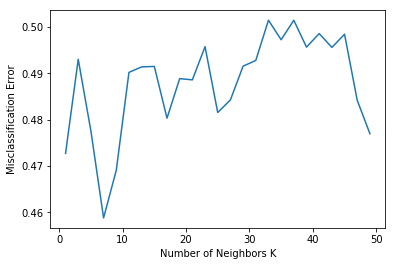

Details for  Bag Of Words Vectorization:
****************************************************************************************************
Accuracy for kd_tree  algorithm with K = 7  is  56.0

 clasification report for kd_tree  algorithm with K = 7  is 
               precision    recall  f1-score   support

   negative       0.57      0.60      0.58       156
   positive       0.54      0.52      0.53       144

avg / total       0.56      0.56      0.56       300


 confussion matrix for kd_tree  algorithm with K = 7  is 
 [[93 63]
 [69 75]]


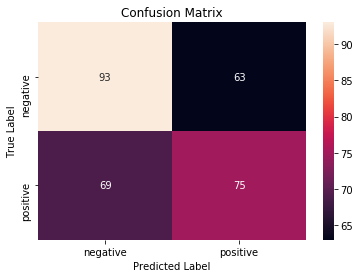

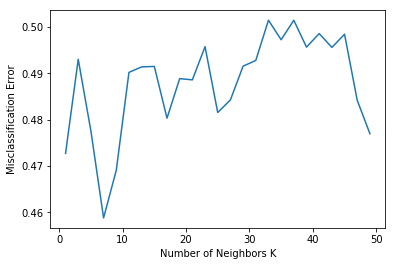

Details for  Bag Of Words Vectorization:
****************************************************************************************************
Accuracy for brute  algorithm with K = 7  is  56.0

 clasification report for brute  algorithm with K = 7  is 
               precision    recall  f1-score   support

   negative       0.57      0.60      0.58       156
   positive       0.54      0.52      0.53       144

avg / total       0.56      0.56      0.56       300


 confussion matrix for brute  algorithm with K = 7  is 
 [[93 63]
 [69 75]]


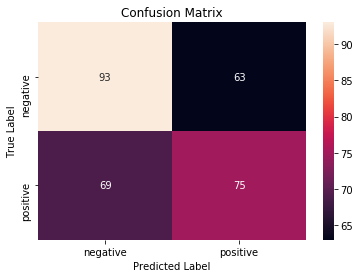

In [96]:
#Optimal K 
optimalk_bow,train_err_bow,test_err_bow = determineknn(X_1,X_test,y_1,y_test,"Bag Of Words")

# Calculating optimal K value and accuracy when K = optimal K for Td-Idf

In [64]:
tf_idf_vec = TfidfVectorizer(ngram_range=(1,2)).fit(X)

X_tr_vectorized = tf_idf_vec.transform(X_1)
X_ts_vectorized = tf_idf_vec.transform(X_test)

In [32]:
from sklearn.preprocessing import StandardScaler

X_1 = StandardScaler(with_mean = False).fit_transform(X_tr_vectorized)

X_test = StandardScaler(with_mean = False).fit_transform(X_ts_vectorized)

X_1.shape

(7000, 238873)

In [33]:
X_test.shape

(3000, 238873)

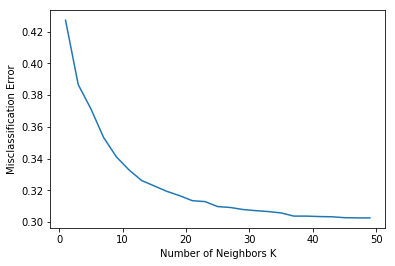

Details for  TF-IDF Vectorization:
****************************************************************************************************
Accuracy for kd_tree  algorithm with K = 47  is  70.0

 clasification report for kd_tree  algorithm with K = 47  is 
               precision    recall  f1-score   support

   negative       0.40      0.01      0.02       886
   positive       0.71      0.99      0.83      2114

avg / total       0.62      0.70      0.59      3000


 confussion matrix for kd_tree  algorithm with K = 47  is 
 [[   8  878]
 [  12 2102]]


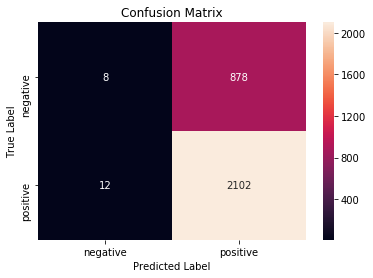

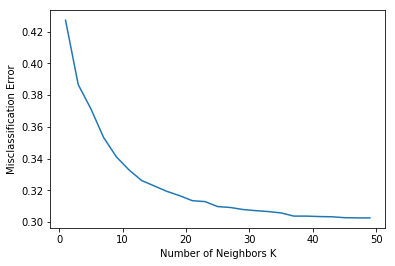

Details for  TF-IDF Vectorization:
****************************************************************************************************
Accuracy for brute  algorithm with K = 47  is  70.0

 clasification report for brute  algorithm with K = 47  is 
               precision    recall  f1-score   support

   negative       0.40      0.01      0.02       886
   positive       0.71      0.99      0.83      2114

avg / total       0.62      0.70      0.59      3000


 confussion matrix for brute  algorithm with K = 47  is 
 [[   8  878]
 [  12 2102]]


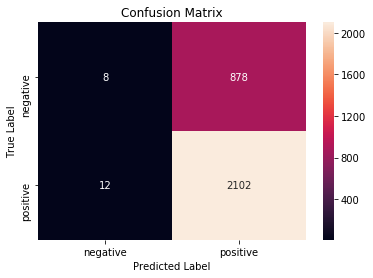

In [34]:
optimalk_tfidf,train_err_tfidf,test_err_tfidf = determineknn(X_1,X_test,y_1,y_test,'TF-IDF')

# Calculating optimal K value and accuracy when K = optimal K for W2V

In [41]:
# Using Google News Word2Vectors
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

In [42]:
X_1.shape

(7000,)

In [43]:
import gensim
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sent=[]
for sent in X_1.values:  # Train my W2V using train data
    list_of_sent.append(sent.split())

In [44]:
w2v_model=Word2Vec(list_of_sent,min_count=5,size=50, workers=4)    

In [45]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  3881
sample words  ['product', 'mani', 'artifici', 'ingredi', 'sweeten', 'good', 'make', 'rice', 'milk', 'water', 'look', 'onlin', 'recip', 'order', 'hope', 'would', 'nice', 'addit', 'assort', 'aw', 'one', 'tri', 'want', 'anoth', 'cup', 'ever', 'took', 'work', 'bomb', 'call', 'amazon', 'complain', 'tast', 'seem', 'over', 'sweet', 'like', 'pleas', 'money', 'fulli', 'refund', 'told', 'keep', 'cannot', 'return', 'thought', 'might', 'abl', 'give', 'away']


In [46]:
len(list_of_sent)

7000

# Avg W2V - Train

In [47]:
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

7000
50


# Avg W2V - Test

In [66]:
list_of_sent_test=[]
for sent in X_test.values:  # Train my W2V using train data
    list_of_sent_test.append(sent.split())
    
len(list_of_sent_test)

3000

In [49]:
# compute average word2vec for each review.
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent_test: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))

3000
50


In [50]:
X_1 = np.array(sent_vectors).reshape(7000,50)

X_test = np.array(sent_vectors_test).reshape(3000,50)

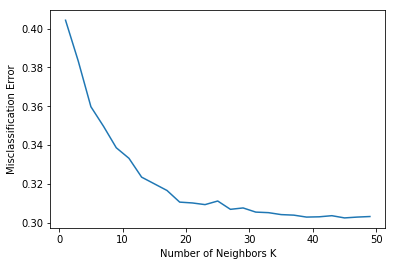

Details for  Avg W2V Vectorization:
****************************************************************************************************
Accuracy for kd_tree  algorithm with K = 45  is  70.0

 clasification report for kd_tree  algorithm with K = 45  is 
               precision    recall  f1-score   support

   negative       0.44      0.03      0.06       886
   positive       0.71      0.98      0.82      2114

avg / total       0.63      0.70      0.60      3000


 confussion matrix for kd_tree  algorithm with K = 45  is 
 [[  31  855]
 [  39 2075]]


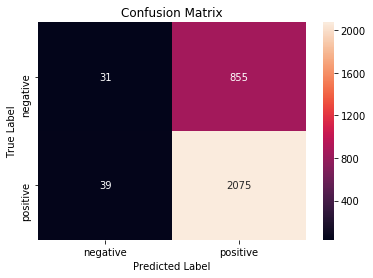

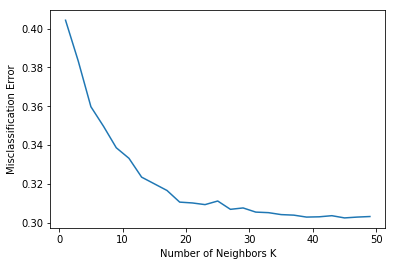

Details for  Avg W2V Vectorization:
****************************************************************************************************
Accuracy for brute  algorithm with K = 45  is  70.0

 clasification report for brute  algorithm with K = 45  is 
               precision    recall  f1-score   support

   negative       0.44      0.03      0.06       886
   positive       0.71      0.98      0.82      2114

avg / total       0.63      0.70      0.60      3000


 confussion matrix for brute  algorithm with K = 45  is 
 [[  31  855]
 [  39 2075]]


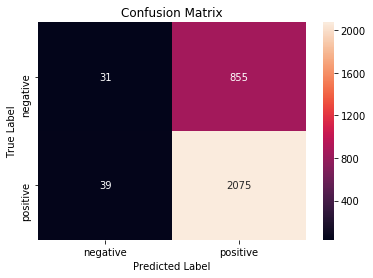

In [51]:
optimalk_AvgW2V,train_err_AvgW2V,test_err_AvgW2V = determineknn(X_1,X_test,y_1,y_test,"Avg W2V")

# Tf-Idf Weighted W2V

In [56]:
tf_idf_vec = TfidfVectorizer(ngram_range=(1,2))

X_1 = tf_idf_vec.fit_transform(X_1)

X_1.shape

(7000, 180949)

In [57]:
X_test = tf_idf_vec.transform(X_test)
X_test.shape

(3000, 180949)

# Tf-Idf Weighted W2V - Train

In [65]:
tfidf_feat = tf_idf_vec.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent: # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = X_tr_vectorized[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

In [68]:
len(tfidf_sent_vectors[0])

50

# Tf-Idf Weighted W2V - Test

In [69]:
tfidf_feat = tf_idf_vec.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent_test: # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = X_ts_vectorized[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1

In [70]:
len(tfidf_sent_vectors[0])

50

In [71]:
X_test = np.array(tfidf_sent_vectors_test).reshape(3000,50)

In [72]:
X_1=np.array(tfidf_sent_vectors).reshape(7000,50)

X_1.shape

(7000, 50)

# Optimal K and test data accuracy calculation

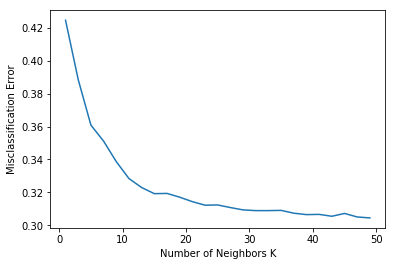

Details for  TfIdf W2V Vectorization:
****************************************************************************************************
Accuracy for kd_tree  algorithm with K = 49  is  70.0

 clasification report for kd_tree  algorithm with K = 49  is 
               precision    recall  f1-score   support

   negative       0.42      0.01      0.02       886
   positive       0.71      0.99      0.83      2114

avg / total       0.62      0.70      0.59      3000


 confussion matrix for kd_tree  algorithm with K = 49  is 
 [[  11  875]
 [  15 2099]]


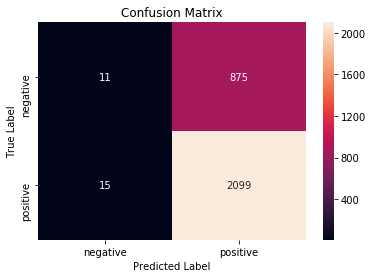

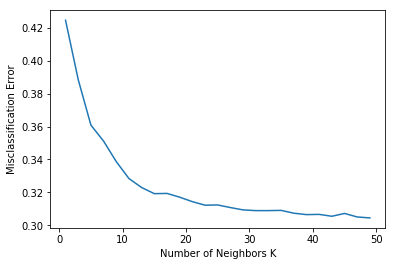

Details for  TfIdf W2V Vectorization:
****************************************************************************************************
Accuracy for brute  algorithm with K = 49  is  70.0

 clasification report for brute  algorithm with K = 49  is 
               precision    recall  f1-score   support

   negative       0.42      0.01      0.02       886
   positive       0.71      0.99      0.83      2114

avg / total       0.62      0.70      0.59      3000


 confussion matrix for brute  algorithm with K = 49  is 
 [[  11  875]
 [  15 2099]]


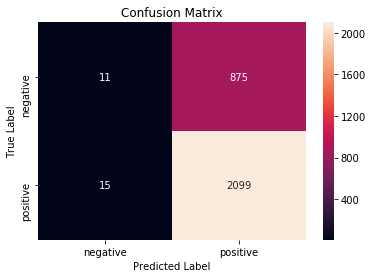

In [73]:
optimalk_tfidf_W2V,train_err_tfidf_W2V,test_err_tfidf_W2V = determineknn(X_1,X_test,y_1,y_test,"TfIdf W2V")

In [85]:
# As there was a mistake in the code to calculate test_err_bow I had to add it with 101 to get the exact value.
# It is taking a day long to run this so I have manipuated wihile displaying.

models = pd.DataFrame({'Model': ['KNN with Bow', "KNN with TFIDF", "KNN with Avg_w2v", "KNN with tfidf_w2v"], 
                       'Hyper Parameter(K)': [optimalk_bow, optimalk_tfidf, optimalk_AvgW2V, optimalk_tfidf_W2V], 
                       'Train Error': [train_err_bow*100, train_err_tfidf*100, train_err_AvgW2V*100, train_err_tfidf_W2V*100], 
                       'Test Error': [101 + test_err_bow, 101+ test_err_tfidf,101+ test_err_AvgW2V,101+ test_err_tfidf_W2V]}, 
                      columns = ["Model", "Hyper Parameter(K)", "Train Error", "Test Error"])

In [86]:
models.sort_values(by='Test Error')

,Model,Hyper Parameter(K),Train Error,Test Error
1,KNN with TFIDF,47,30.157143,31.666667
3,KNN with tfidf_w2v,49,30.128571,31.666667
2,KNN with Avg_w2v,45,29.728571,31.800000
0,KNN with Bow,39,29.842857,32.766667
